## **🛠️ Step 1 — Reset Runtime Environment**  

In this step, we reset the Colab runtime session.  
This helps us clear out all previously loaded variables, models, and data, so we can start with a **fresh environment** for training our new model.


In [ ]:
from google.colab import runtime
runtime.unassign()

## **📦 Step 2 — Install Required Packages**  

Here, we install all the **necessary dependencies** to run our project smoothly in Google Colab.  
This includes numerical libraries, image augmentation tools, computer vision utilities, and the latest GPU-enabled PyTorch stack for training our model.  


In [ ]:
# ============================================================
# Setup: Install required packages (Colab-friendly)
# ============================================================

!pip install --quiet --no-cache-dir \
  numpy==2.1.1 \
  scipy==1.14.1 \
  albucore==0.0.14 \
  albumentations==1.4.13 \
  opencv-python==4.10.0.84 \
  torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement numpy==2.1.1 (from versions: 1.26.2, 1.26.3, 2.1.2)
ERROR: No matching distribution found for numpy==2.1.1


## **🧾 Step 3 — Verify Installations**  

In this step, we quickly **check and print the versions** of our key libraries (NumPy, Albumentations, OpenCV, and PyTorch) to make sure everything is installed correctly before moving forward.  


In [ ]:
import numpy as np, albumentations as A, cv2, torch
print("NumPy:", np.__version__)
print("Albumentations:", A.__version__)
print("OpenCV:", cv2.__version__)
print("Torch:", torch.__version__)


NumPy: 2.0.2
Albumentations: 2.0.8
OpenCV: 4.12.0
Torch: 2.8.0+cu126


## **📌 Step 4 — Imports & Global Config**  

Here we bring in all the **essential Python libraries and utilities** that we’ll be using throughout the project:  

- 🔹 **Core utilities**: `os`, `glob`, `random`, `math`, `time`, and `Path` help with file management and workflow.  
- 🔹 **Data handling & visualization**: `numpy`, `cv2`, and `matplotlib` for arrays, image processing, and plotting.  
- 🔹 **PyTorch ecosystem**: core modules like `torch`, `nn`, `F`, and `DataLoader` for building and training our deep learning models.  
- 🔹 **Albumentations**: a fast and flexible library for image augmentations, with `ToTensorV2` for PyTorch compatibility.  
- 🔹 **scikit-learn**: `StratifiedShuffleSplit` ensures balanced dataset splitting for fair evaluation.  
- 🔹 **Image processing helpers**: `find_boundaries` (for boundary maps) and `distance_transform_edt` (for distance transforms).  

This step sets the **foundation** of our environment, giving us all the tools needed for data preparation, augmentation, model design, and evaluation.  


In [ ]:
# ============================================================
# Imports & Global Config
# ============================================================
import os, glob, random, math, time, copy
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedShuffleSplit

from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt




## **📌 Step 3 — Global Configuration Setup**  

Now we define the **global configuration parameters** that will guide our entire training pipeline. These values control everything from dataset paths to training behavior. Let’s break them down:  

- 📂 **Data paths**:  
  - `DATA_DIR` → main folder containing images and masks.  
  - `IM_DIR` & `MASK_DIR` → direct subpaths for input images and segmentation masks.  

- 🖼 **Image & data settings**:  
  - `IMG_SIZE` → resize all images to 256×256 (can increase to 320 if GPU allows).  
  - `BATCH_SIZE` → number of samples processed together in one training step.  
  - `NUM_WORKERS` → parallel data loading threads for efficiency.  

- ⚙️ **Training hyperparameters**:  
  - `EPOCHS = 100` → total training iterations over the dataset.  
  - `LR = 1e-3` → learning rate, controlling model weight updates.  
  - `WEIGHT_DECAY = 1e-4` → helps reduce overfitting by penalizing large weights.  

- 💻 **Hardware & saving**:  
  - `DEVICE` → automatically selects **GPU (cuda)** if available, otherwise CPU.  
  - `SAVE_DIR` → directory for saving model checkpoints.  

- 🏆 **Model selection**:  
  - `BEST_METRIC = "dice"` → we’ll use **Dice score** (or boundary F1 if chosen) to pick the best model.  

- 🎲 **Reproducibility**:  
  - `SEED = 42` ensures consistent results across runs.  

Finally, we create the checkpoint folder if it doesn’t exist, and print out the device being used. 🚀  


In [ ]:
# ---- Config ----
DATA_DIR         = "/content/drive/MyDrive/Kwsir_Seg_Research"
IM_DIR           = f"{DATA_DIR}/images"
MASK_DIR         = f"{DATA_DIR}/masks"
IMG_SIZE         = 256                    # set to 320 if GPU memory allows
BATCH_SIZE       = 8
NUM_WORKERS      = 2
EPOCHS           = 100
LR               = 1e-3
WEIGHT_DECAY     = 1e-4
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR         = "checkpoints"
BEST_METRIC      = "dice"                 # choose "dice" or "bf" for model selection
SEED             = 42
os.makedirs(SAVE_DIR, exist_ok=True)

print("Device:", DEVICE)

Device: cuda


## **📌 Step 6 — Ensuring Reproducibility 🔄**  

Deep learning experiments can sometimes produce slightly different results across runs because of **random initialization, data shuffling, and GPU operations**. To keep our results **consistent and comparable**, we set a fixed random seed.  

Here’s what happens inside our `set_seed()` function:  

- 🎲 `random.seed(seed)` → fixes randomness in Python’s built-in random module.  
- 🔢 `np.random.seed(seed)` → ensures NumPy operations are reproducible.  
- ⚡ `torch.manual_seed(seed)` & `torch.cuda.manual_seed_all(seed)` → fix randomness for CPU and GPU tensors.  
- 🧩 `torch.backends.cudnn.deterministic = False` & `benchmark = True` → allow cuDNN to optimize computations for speed while maintaining reasonable consistency.  

By calling `set_seed(SEED)`, we lock down the experiment’s randomness as much as possible while still keeping GPU acceleration efficient. 🚀  


In [ ]:
# ============================================================
# Reproducibility Helpers
# ============================================================
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)


## **📌 Step 7 — Utility Functions for Visualization 🎨**  

Before diving into training, it’s important that we can **visually inspect our data, masks, and predictions**. To make this easier, we define two helper functions:  

### 🖌️ `overlay_mask_on_image(img, mask, alpha=0.5)`  
- Takes an **RGB image** (`img`) and a **binary mask** (`mask`).  
- Creates a **red overlay** on top of the image where the mask is active.  
- `alpha` controls the transparency of the overlay (0 = invisible, 1 = full red).  
- Helps us quickly see where the segmentation mask lies on the original image.  

### 🖼️ `show_samples(images, masks, preds=None, n=4, title="Samples")`  
- Displays up to `n` samples side by side.  
- For each sample, it shows:  
  1. 📷 Original Image  
  2. 🎭 Ground Truth Mask  
  3. 🔴 Overlay of Mask on Image  
  4. (Optional) 🔮 Predicted Mask Overlay if `preds` are provided  
- Ensures our model’s outputs can be **visually validated** against the ground truth.  

✅ These functions will be our go-to tools whenever we want to **monitor training progress, debug errors, or present results visually**.  


In [ ]:
# ============================================================
# Utility: Overlay and Visualization
# ============================================================
def overlay_mask_on_image(img, mask, alpha=0.5):
    """
    img: (H,W,3) float32 in [0,1]
    mask: (H,W) float32 or bool in {0,1}
    Returns RGB overlay.
    """
    img = img.copy()
    if mask.dtype != np.float32:
        mask = mask.astype(np.float32)
    mask_3 = np.stack([mask, np.zeros_like(mask), np.zeros_like(mask)], axis=-1)  # red overlay
    overlay = img*(1-alpha) + mask_3*alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

def show_samples(images, masks, preds=None, n=4, title="Samples"):
    """
    images: torch.Tensor (B,3,H,W) or list of numpy
    masks:  torch.Tensor (B,1,H,W)
    preds:  torch.Tensor (B,1,H,W) probabilities or None
    """
    b = min(n, len(images))
    plt.figure(figsize=(12, 3*b))
    for i in range(b):
        if torch.is_tensor(images):
            img = images[i].permute(1,2,0).cpu().numpy()
            # de-normalize from z-score to [0,1] (approx, since we used per-image z-score)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        else:
            img = images[i]
        mask = masks[i].squeeze().cpu().numpy()
        ov   = overlay_mask_on_image(img, mask>0.5)
        plt.subplot(b, 4, 4*i+1); plt.imshow(img); plt.axis('off'); plt.title("Image")
        plt.subplot(b, 4, 4*i+2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title("Mask")
        plt.subplot(b, 4, 4*i+3); plt.imshow(ov); plt.axis('off'); plt.title("Overlay")
        if preds is not None:
            pm = (preds[i].squeeze().cpu().numpy()>0.5).astype(np.float32)
            pov = overlay_mask_on_image(img, pm)
            plt.subplot(b, 4, 4*i+4); plt.imshow(pov); plt.axis('off'); plt.title("Pred Overlay")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## **📌 Step 8 — Data Augmentation with Albumentations 🧩**  

To make our model more **robust and generalizable**, we apply a series of **Albumentations transforms** for preprocessing and augmentation. These transforms handle both **images and masks** while preserving alignment.  

### ⚙️ How it works:  
- **Aspect-Ratio Preserving Resize**  
  - `LongestMaxSize`: Resizes so the longest side matches `img_size`.  
  - `PadIfNeeded`: Pads the rest to form a square image (with black borders).  

- **Train-Time Augmentations (for diversity)** 🌈  
  - 🔄 `HorizontalFlip` (50%) & `VerticalFlip` (20%) → simulate different orientations.  
  - 📐 `ShiftScaleRotate` → small shifts, zooms, and rotations.  
  - 🌊 `ElasticTransform` → adds slight elastic deformations.  
  - 👓 `GaussianBlur` → mimics blur/noise.  
  - 🎨 `ColorJitter` & `RandomBrightnessContrast` → adjust colors & lighting.  
  - 🌞 `RandomSunFlare` → simulate specular highlights.  
  - 🕳️ `CoarseDropout` → randomly occludes patches (like Cutout).  
  - ⚡ `CLAHE` (Contrast Limited Adaptive Histogram Equalization) → enhances local contrast.  

- **Validation/Test Augmentations** (lighter)  
  - Only a light `CLAHE` is applied for subtle contrast improvement.  

- **Final Normalization & Tensor Conversion**  
  - `Normalize(mean=0, std=1)` as a placeholder (we’ll apply **per-image z-score** later).  
  - `ToTensorV2()` converts everything into **PyTorch tensors**.  

✅ With these augmentations, our model learns to handle **real-world variations** like brightness, blur, occlusions, and random distortions.  


In [ ]:
# ============================================================
# Albumentations Transforms (Resize with aspect ratio)
# ============================================================
def get_transforms(split="train", img_size=IMG_SIZE):
    # Keep aspect ratio -> LongestMaxSize + PadIfNeeded
    base_resize = [
        A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_LINEAR),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    ]
    if split == "train":
        aug = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
            A.ElasticTransform(alpha=50, sigma=7, alpha_affine=10, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
            A.GaussianBlur(blur_limit=(3,5), p=0.2),
            A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.RandomSunFlare(src_radius=60, p=0.2),  # specular-ish highlight
            A.CoarseDropout(max_holes=6, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, fill_value=0, mask_fill_value=0, p=0.3),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.25),  # light CLAHE on V-channel internally
        ]
    else:
        aug = [A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.1)]
    tail = [
        A.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),  # we'll do per-image z-score below
        ToTensorV2(),
    ]
    return A.Compose(base_resize + aug + tail)


## **📌 Step 9 — Building the Dataset 📂**  

Now we create a **robust dataset pipeline** to pair images with their masks and prepare them for training.  

### 🔑 Key Features:  
- **Name Matching (robust)**  
  - Uses a `natural_key` sorter to keep files in natural order (e.g., `1,2,10` instead of `1,10,2`).  
  - Matches masks by filename stem (handles cases like `_mask` suffix or different extensions).  

- **`KvasirSegDataset` Class** 🧑‍💻  
  - Reads each **image** (`cv2.imread`) in RGB.  
  - Reads each **mask** in grayscale and binarizes to `{0,1}`.  
  - Supports **Albumentations transforms** for augmentation.  
  - Falls back to PyTorch tensors if no transform is applied.  

- **On-the-fly Normalization** ⚖️  
  - Scales images to `[0,1]`.  
  - Applies **per-image z-score normalization** (subtract mean, divide by std).  
  - Ensures model handles intensity variations consistently.  

- **Final Output**  
  - **Image** → `(3, H, W)` float tensor.  
  - **Mask** → `(1, H, W)` binary tensor.  
  - Also returns the **image path** (useful for debugging/visualization).  

✅ With this setup, we can reliably pair images & masks even if filenames differ slightly, while keeping inputs **clean, normalized, and ready** for training.  


In [ ]:
# ============================================================
# Dataset: Pair images and masks (robust name matching)
# ============================================================
def natural_key(s):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def build_pairs(images_dir, masks_dir):
    img_paths = sorted(glob.glob(os.path.join(images_dir, "*.*")), key=natural_key)
    mask_paths_all = sorted(glob.glob(os.path.join(masks_dir, "*.*")), key=natural_key)

    # Map masks by stem (handle "_mask" suffix)
    mask_map = {}
    for mp in mask_paths_all:
        st = Path(mp).stem.lower()
        st_clean = st.replace("_mask", "")
        mask_map[st] = mp
        mask_map[st_clean] = mp

    pairs = []
    for ip in img_paths:
        st = Path(ip).stem.lower()
        if st in mask_map:
            pairs.append((ip, mask_map[st]))
        elif f"{st}_mask" in mask_map:
            pairs.append((ip, mask_map[f"{st}_mask"]))
        else:
            # try exact filename with png/jpg switch
            candidates = [p for p in mask_paths_all if Path(p).stem.lower().startswith(st)]
            if candidates:
                pairs.append((ip, candidates[0]))
    return pairs

class KvasirSegDataset(Dataset):
    def __init__(self, pairs, transform=None, per_image_zscore=True):
        self.pairs = pairs
        self.transform = transform
        self.per_image_zscore = per_image_zscore

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # BGR
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(mask_path)

        # Ensure binary 0/1
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]  # tensors (C,H,W) and (H,W)
        else:
            img = torch.from_numpy(img).permute(2,0,1)
            mask = torch.from_numpy(mask)

        # per-image z-score normalization on-the-fly
        img = img.float()/255.0 if img.max() > 1 else img.float()
        if self.per_image_zscore:
            # compute mean/std per image over spatial dims
            mean = img.mean(dim=(1,2), keepdim=True)
            std  = img.std(dim=(1,2), keepdim=True) + 1e-6
            img = (img - mean) / std

        mask = mask.float().unsqueeze(0)  # (1,H,W) in {0,1}
        return img, mask, img_path


## **📌 Step 10 — Stratified Data Splitting 📊**  

To ensure our model sees a balanced variety of polyp sizes during training, we perform a **stratified split** based on mask area.  

### 🔑 What We Did:
1. **Pair Collection**  
   - Built image–mask pairs using our robust pairing function.  

2. **Mask Area Calculation**  
   - For each mask, computed the **coverage ratio** = foreground pixels / total pixels.  
   - This gives us a measure of polyp size relative to the image.  

3. **Bin Assignment** 🗂️  
   - Grouped samples into categories (tiny, small, medium, large) using `np.digitize`.  

4. **Stratified Splits**  
   - **Train/Val/Test Split** using `StratifiedShuffleSplit`:  
     - **15%** → Test set.  
     - Remaining **85%** → Further split into Train and Validation.  
   - Ensures each split has a similar distribution of polyp sizes.  

### ✅ Outcome:
We now have three subsets ready:  
- **Training Set** → Majority of data for model learning.  
- **Validation Set** → For tuning hyperparameters & preventing overfitting.  
- **Test Set** → Held-out data for unbiased final evaluation.  

This approach ensures fairness across splits, especially for **tiny vs large polyps**, which could otherwise be underrepresented.  


In [ ]:
# ============================================================
# Stratified Split by Mask Area (tiny vs large polyps)
# ============================================================
pairs = build_pairs(IM_DIR, MASK_DIR)
print(f"Found {len(pairs)} pairs.")

# compute coverage bins for stratification
areas = []
for _, m in pairs:
    m_img = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    if m_img is None: raise FileNotFoundError(m)
    a = float((m_img > 0).sum()) / (m_img.shape[0] * m_img.shape[1] + 1e-6)
    areas.append(a)

areas = np.array(areas)
# bin into categories (tiny/small/medium/large)
bins = np.digitize(areas, bins=[0.001, 0.01, 0.05, 0.1, 0.2], right=False)

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
idx_all = np.arange(len(pairs))
trainval_idx, test_idx = next(sss1.split(idx_all, bins))

bins_trainval = bins[trainval_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1765, random_state=SEED)  # 0.1765 of 85% ≈ 15%
train_idx_rel, val_idx_rel = next(sss2.split(np.arange(len(trainval_idx)), bins_trainval))

train_idx = trainval_idx[train_idx_rel]
val_idx   = trainval_idx[val_idx_rel]

pairs_train = [pairs[i] for i in train_idx]
pairs_val   = [pairs[i] for i in val_idx]
pairs_test  = [pairs[i] for i in test_idx]

print(f"Split -> Train: {len(pairs_train)} | Val: {len(pairs_val)} | Test: {len(pairs_test)}")


Found 1000 pairs.
Split -> Train: 699 | Val: 151 | Test: 150


## **📌 Step 11 — Creating DataLoaders ⚡**  

With our splits ready, we now prepare **PyTorch DataLoaders** to feed data into the model efficiently.  

### 🔑 What We Did:
1. **Applied Transformations**  
   - Used our `get_transforms()` function for train, val, and test sets.  
   - Training uses strong augmentations (flips, rotations, color jitter, etc.).  
   - Validation & test use lighter transformations for consistency.  

2. **Built Datasets**  
   - Wrapped each split (`train`, `val`, `test`) into our custom `KvasirSegDataset`.  
   - Ensured per-image z-score normalization for stable training.  

3. **Constructed DataLoaders** 🛠️  
   - Added batching, shuffling, and parallel data loading with workers.  
   - Used `pin_memory=True` for faster GPU transfers.  

4. **Quick Sanity Check** 👀  
   - Visualized a few training samples with their masks and overlays to confirm data correctness.  

### ✅ Outcome:
We now have **ready-to-use DataLoaders** that can efficiently stream batches of augmented images and masks into the training pipeline.  


/tmp/ipython-input-1105796552.py:8: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1105796552.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=50, sigma=7, alpha_affine=10, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
/tmp/ipython-input-1105796552.py:20: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=6, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, fill_value=0, mask_fill_value=0, p=0.3),


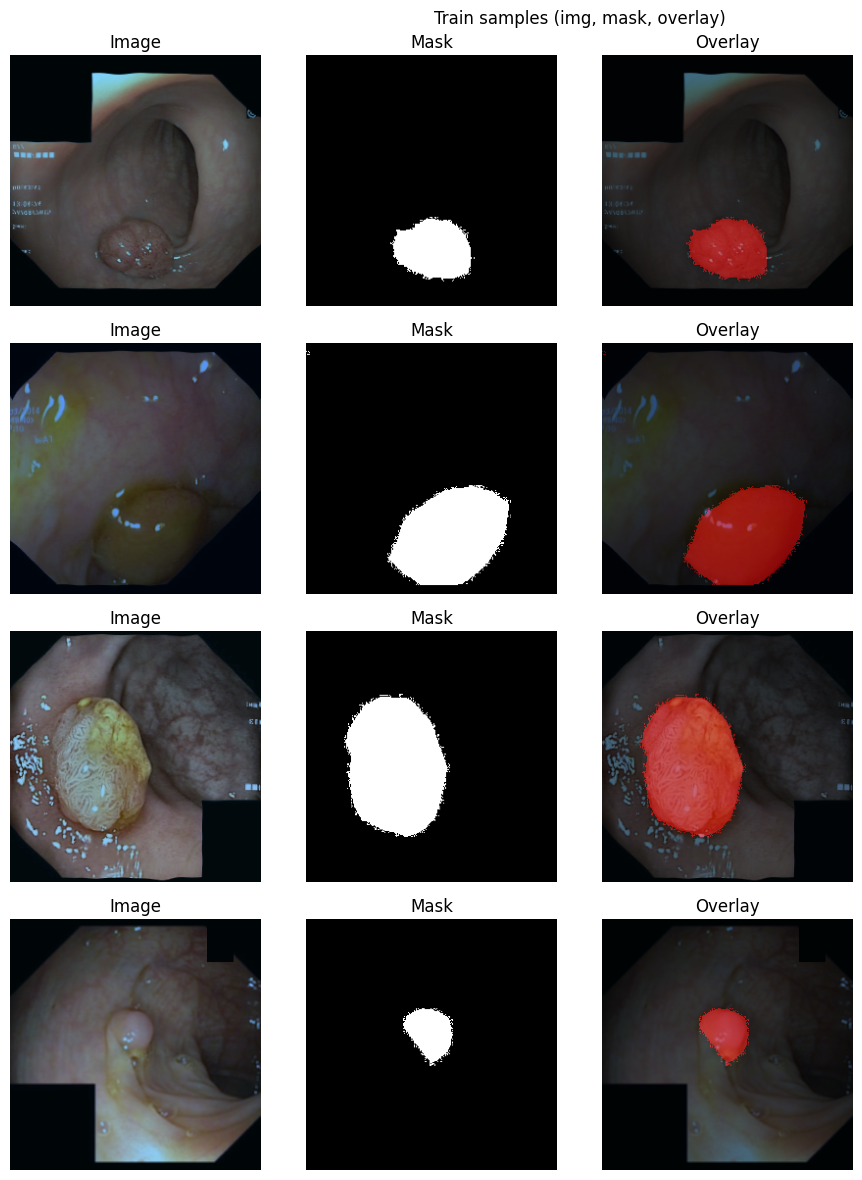

In [ ]:
# ============================================================
# DataLoaders
# ============================================================
train_tfms = get_transforms("train", IMG_SIZE)
val_tfms   = get_transforms("val",   IMG_SIZE)
test_tfms  = get_transforms("test",  IMG_SIZE)

ds_train = KvasirSegDataset(pairs_train, transform=train_tfms)
ds_val   = KvasirSegDataset(pairs_val,   transform=val_tfms, per_image_zscore=True)
ds_test  = KvasirSegDataset(pairs_test,  transform=test_tfms, per_image_zscore=True)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# quick visualization of a few training samples
imgs, masks, _ = next(iter(dl_train))
show_samples(imgs, masks, preds=None, n=4, title="Train samples (img, mask, overlay)")


## **🔢 Step 12 – U-Net Architecture (with Bilinear Upsample + Conv)**

This step defines our **U-Net model**, which is widely used for image segmentation.  
It combines an **encoder (downsampling)** and **decoder (upsampling)** with skip connections.  

---

## 12.1 🧱 ConvBlock
- Contains two `Conv2d → BatchNorm → ReLU` layers  
- Maintains spatial resolution (padding=1)  
- Learns **local texture features**  

---

## 12.2 🔼 UpBlock
- Performs **upsampling** (restores resolution) + **skip connections** (adds encoder info)  
- Two modes:
  - `bilinear=True`: simple `nn.Upsample` (lightweight, fast)  
  - `bilinear=False`: `ConvTranspose2d` (learnable upsampling)  
- After alignment → concatenates encoder + decoder features  
- Passes through a `ConvBlock` to refine  

---

## 12.3 🏗 Full U-Net Model
1. **Encoder (Down path)**  
   - First `ConvBlock` → low-level features  
   - Each down step = `MaxPool2d` (reduce resolution) + `ConvBlock`  

2. **Bottleneck**  
   - Deepest representation with widest feature channels  

3. **Decoder (Up path)**  
   - Each up step: upsample → concatenate with skip connection → `ConvBlock`  
   - Gradually rebuilds image resolution  

4. **Output Layer**  
   - `nn.Conv2d(..., out_ch, 1)` → segmentation mask with desired output channels  


In [ ]:
# ============================================================
# Model: U-Net (bilinear upsample + conv)
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
            self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, widths=(64,128,256,512), bilinear=True):
        super().__init__()
        w1,w2,w3,w4 = widths
        factor = 2 if bilinear else 1
        self.inc   = ConvBlock(in_ch, w1)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(w1, w2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(w2, w3))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(w3, w4))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(w4, w4*2//factor))
        self.up1   = UpBlock(w4*2, w4//factor, bilinear)
        self.up2   = UpBlock(w4,   w3//factor, bilinear)
        self.up3   = UpBlock(w3,   w2//factor, bilinear)
        self.up4   = UpBlock(w2,   w1, bilinear)
        self.outc  = nn.Conv2d(w1, out_ch, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        logits = self.outc(x)
        return logits


## **🔢 Step 13 – Losses & Metrics**

For segmentation, we use losses that handle imbalance and metrics that check overlap & boundaries.

- **Dice Loss** → maximizes overlap between predicted and true masks.  
- **Focal Tversky Loss** → variant of Dice, better for tiny objects (balances FP & FN).  

**Evaluation Metrics:**  
- **Dice Coefficient** → measures overlap (higher = better).  
- **IoU (Jaccard Index)** → stricter overlap measure.  
- **Boundary F1** → checks edge accuracy within a tolerance (important for precise polyp borders).  


In [ ]:
# ============================================================
# Losses & Metrics (Dice, IoU, Boundary F1)
# ============================================================
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        # logits: (B,1,H,W) raw
        probs = torch.sigmoid(logits)
        num = 2 * (probs*targets).sum(dim=(2,3)) + self.smooth
        den = (probs**2 + targets**2).sum(dim=(2,3)) + self.smooth
        dice = num/den
        return 1 - dice.mean()

class FocalTverskyLoss(nn.Module):
    # optional if tiny masks dominate
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1.0):
        super().__init__()
        self.a, self.b, self.g = alpha, beta, gamma
        self.smooth = smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        tp = (p*targets).sum(dim=(2,3))
        fp = (p*(1-targets)).sum(dim=(2,3))
        fn = ((1-p)*targets).sum(dim=(2,3))
        tversky = (tp + self.smooth) / (tp + self.a*fp + self.b*fn + self.smooth)
        return (1 - tversky).pow(self.g).mean()

def dice_coef(preds, targets, thr=0.5, eps=1e-7):
    preds = (preds > thr).float()
    inter = (preds*targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def iou_coef(preds, targets, thr=0.5, eps=1e-7):
    preds = (preds > thr).float()
    inter = (preds*targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

def boundary_f1(preds, targets, thr=0.5, tol=2):
    """
    Boundary F1 with tolerance (in pixels).
    preds/targets: torch.Tensor (B,1,H,W) probabilities/0-1
    """
    preds = (preds > thr).detach().cpu().numpy().astype(np.uint8)
    targets = targets.detach().cpu().numpy().astype(np.uint8)
    B = preds.shape[0]
    f1s = []
    for b in range(B):
        pr = preds[b,0]
        gt = targets[b,0]

        pr_b = find_boundaries(pr, mode='outer').astype(np.uint8)
        gt_b = find_boundaries(gt, mode='outer').astype(np.uint8)

        # distance to nearest boundary pixel
        dt_pr = distance_transform_edt(1 - pr_b)
        dt_gt = distance_transform_edt(1 - gt_b)

        # matches: boundary pixels within tolerance
        pr_match = (dt_gt <= tol) & (pr_b == 1)
        gt_match = (dt_pr <= tol) & (gt_b == 1)

        tp_pr = pr_match.sum()
        tp_gt = gt_match.sum()

        prec = tp_pr / (pr_b.sum() + 1e-6)
        rec  = tp_gt / (gt_b.sum() + 1e-6)
        if prec+rec == 0:
            f1 = 0.0
        else:
            f1 = 2*prec*rec / (prec+rec+1e-6)
        f1s.append(f1)
    return float(np.mean(f1s))


## **⚡ Step 14 – Training & Evaluation Loop**

We define the training and validation process with support for **mixed precision** (faster training on GPU) and **checkpointing**.

- **train_one_epoch** → runs a full training pass, combining **BCE + Dice loss**, updates weights, and tracks metrics (Dice, IoU, Boundary F1).  
- **eval_one_epoch** → evaluates without gradient updates, returns metrics + a small batch for visualization.  
- **save_ckpt** → saves model/optimizer state so training can resume later.  


In [ ]:
# ============================================================
# Train/Eval Loop (mixed precision + checkpointing)
# ============================================================
def train_one_epoch(model, loader, optimizer, scaler, criterion_bce, criterion_dice, device=DEVICE):
    model.train()
    loss_meter, dice_meter, iou_meter, bf_meter = [], [], [], []
    for imgs, masks, _ in loader:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(imgs)
            bce = criterion_bce(logits, masks)
            dice = criterion_dice(logits, masks)
            loss = bce + dice
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            loss_meter.append(loss.item())
            dice_meter.append(dice_coef(probs, masks))
            iou_meter.append(iou_coef(probs, masks))
            bf_meter.append(boundary_f1(probs, masks))

    return {
        "loss": float(np.mean(loss_meter)),
        "dice": float(np.mean(dice_meter)),
        "iou":  float(np.mean(iou_meter)),
        "bf":   float(np.mean(bf_meter)),
    }

@torch.no_grad()
def eval_one_epoch(model, loader, criterion_bce, criterion_dice, device=DEVICE):
    model.eval()
    loss_meter, dice_meter, iou_meter, bf_meter = [], [], [], []
    all_imgs, all_masks, all_probs = [], [], []
    for imgs, masks, _ in loader:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        logits = model(imgs)
        bce = criterion_bce(logits, masks)
        dice_l = criterion_dice(logits, masks)
        loss = bce + dice_l
        probs = torch.sigmoid(logits)

        loss_meter.append(loss.item())
        dice_meter.append(dice_coef(probs, masks))
        iou_meter.append(iou_coef(probs, masks))
        bf_meter.append(boundary_f1(probs, masks))

        # stash a small batch for visualization
        if len(all_imgs) < 1:
            all_imgs = imgs.detach().cpu()
            all_masks = masks.detach().cpu()
            all_probs = probs.detach().cpu()

    metrics = {
        "loss": float(np.mean(loss_meter)),
        "dice": float(np.mean(dice_meter)),
        "iou":  float(np.mean(iou_meter)),
        "bf":   float(np.mean(bf_meter)),
    }
    viz = (all_imgs, all_masks, all_probs)
    return metrics, viz

def save_ckpt(model, optimizer, epoch, path):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
    }, path)


## **⚡ Step 15 – Model, Losses, Optimizer & Scheduler**

- **Model** → U-Net with bilinear upsampling.  
- **Losses** → Binary Cross-Entropy + Dice Loss (can switch to Focal Tversky if needed).  
- **Optimizer** → AdamW with weight decay.  
- **Scheduler** → Cosine Annealing to smoothly reduce learning rate.  
- **Scaler** → Enables mixed precision on GPU for efficiency.  
- **Early stopping setup** → Tracks best validation score and patience to prevent overfitting.  


In [ ]:
# ============================================================
# Initialize Model, Opt, Scheduler, Losses
# ============================================================
model = UNet(in_ch=3, out_ch=1, widths=(64,128,256,512), bilinear=True).to(DEVICE)

criterion_bce  = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()   # swap to FocalTverskyLoss() if we need

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

best_val = -1.0
patience = 20
bad_epochs = 0
best_path = os.path.join(SAVE_DIR, f"unet_best_{BEST_METRIC}.pth")


/tmp/ipython-input-1914228946.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


## **🚀 Step 16 – Training Loop with Early Stopping**

- **Epoch loop** → Trains and validates for each epoch.  
- **Metrics monitored** → Loss, Dice, IoU, Boundary F1.  
- **Learning rate** → Updated each epoch using cosine annealing.  
- **Checkpointing** → Saves the best model based on chosen metric (`dice` or `bf`).  
- **Early stopping** → Stops training if no improvement for a set number of epochs.  
- **Optional in-loop visualization** → Quick sanity check of predictions each epoch.  


In [ ]:
# ============================================================
# Training Loop with Early Stopping + In-Loop Viz
# ============================================================
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_metrics = train_one_epoch(model, dl_train, optimizer, scaler, criterion_bce, criterion_dice, DEVICE)
    val_metrics, viz = eval_one_epoch(model, dl_val, criterion_bce, criterion_dice, DEVICE)
    scheduler.step()

    metric_key = BEST_METRIC
    monitor = val_metrics[metric_key]
    improved = monitor > best_val
    if improved:
        best_val = monitor
        bad_epochs = 0
        save_ckpt(model, optimizer, epoch, best_path)
    else:
        bad_epochs += 1

    print(f"Epoch {epoch:03d}/{EPOCHS} | "
          f"Train: loss={train_metrics['loss']:.4f}, dice={train_metrics['dice']:.4f}, iou={train_metrics['iou']:.4f}, bf={train_metrics['bf']:.4f} | "
          f"Val:   loss={val_metrics['loss']:.4f}, dice={val_metrics['dice']:.4f}, iou={val_metrics['iou']:.4f}, bf={val_metrics['bf']:.4f} | "
          f"lr={scheduler.get_last_lr()[0]:.6f} | "
          f"{'✅ Saved best' if improved else ''} | {time.time()-t0:.1f}s")

    # quick visual for sanity each epoch (first few of val batch)
    #imgs_v, masks_v, probs_v = viz
    #show_samples(imgs_v, masks_v, preds=probs_v, n=min(3, len(imgs_v)), title=f"Val predictions (Epoch {epoch})")

    if bad_epochs >= patience:
        print(f"Early stopping at epoch {epoch}. Best {metric_key}={best_val:.4f}")
        break

print("Best model saved to:", best_path)


/tmp/ipython-input-55083584.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 001/100 | Train: loss=0.9023, dice=0.3844, iou=0.2714, bf=0.0968 | Val:   loss=1.1122, dice=0.4253, iou=0.2930, bf=0.0803 | lr=0.001000 | ✅ Saved best | 370.9s
Epoch 002/100 | Train: loss=0.8089, dice=0.4183, iou=0.2997, bf=0.1017 | Val:   loss=0.7611, dice=0.4895, iou=0.3538, bf=0.1193 | lr=0.000999 | ✅ Saved best | 35.8s
Epoch 003/100 | Train: loss=0.7732, dice=0.4389, iou=0.3168, bf=0.1048 | Val:   loss=0.7562, dice=0.4144, iou=0.2978, bf=0.1094 | lr=0.000998 |  | 37.3s
Epoch 004/100 | Train: loss=0.7571, dice=0.4565, iou=0.3331, bf=0.1157 | Val:   loss=0.7738, dice=0.4597, iou=0.3256, bf=0.1153 | lr=0.000996 |  | 35.7s
Epoch 005/100 | Train: loss=0.7452, dice=0.4691, iou=0.3425, bf=0.1269 | Val:   loss=0.6991, dice=0.4973, iou=0.3680, bf=0.1309 | lr=0.000994 | ✅ Saved best | 37.2s
Epoch 006/100 | Train: loss=0.7358, dice=0.4814, iou=0.3570, bf=0.1445 | Val:   loss=0.7408, dice=0.4033, iou=0.3012, bf=0.1141 | lr=0.000991 |  | 35.2s
Epoch 007/100 | Train: loss=0.7362, dice=0.47

## **🧪 Step 17 – Evaluate Best Model on Test Set**

- 🔄 **Load checkpoint** → Restores the best saved model weights.  
- 📊 **Test evaluation** → Reports final metrics (Loss, Dice, IoU, Boundary F1).  
- 👀 **Visualization** → Displays a few sample predictions with masks and overlays.  


[TEST] loss=0.2825 | dice=0.8256 | iou=0.7338 | bf=0.5680


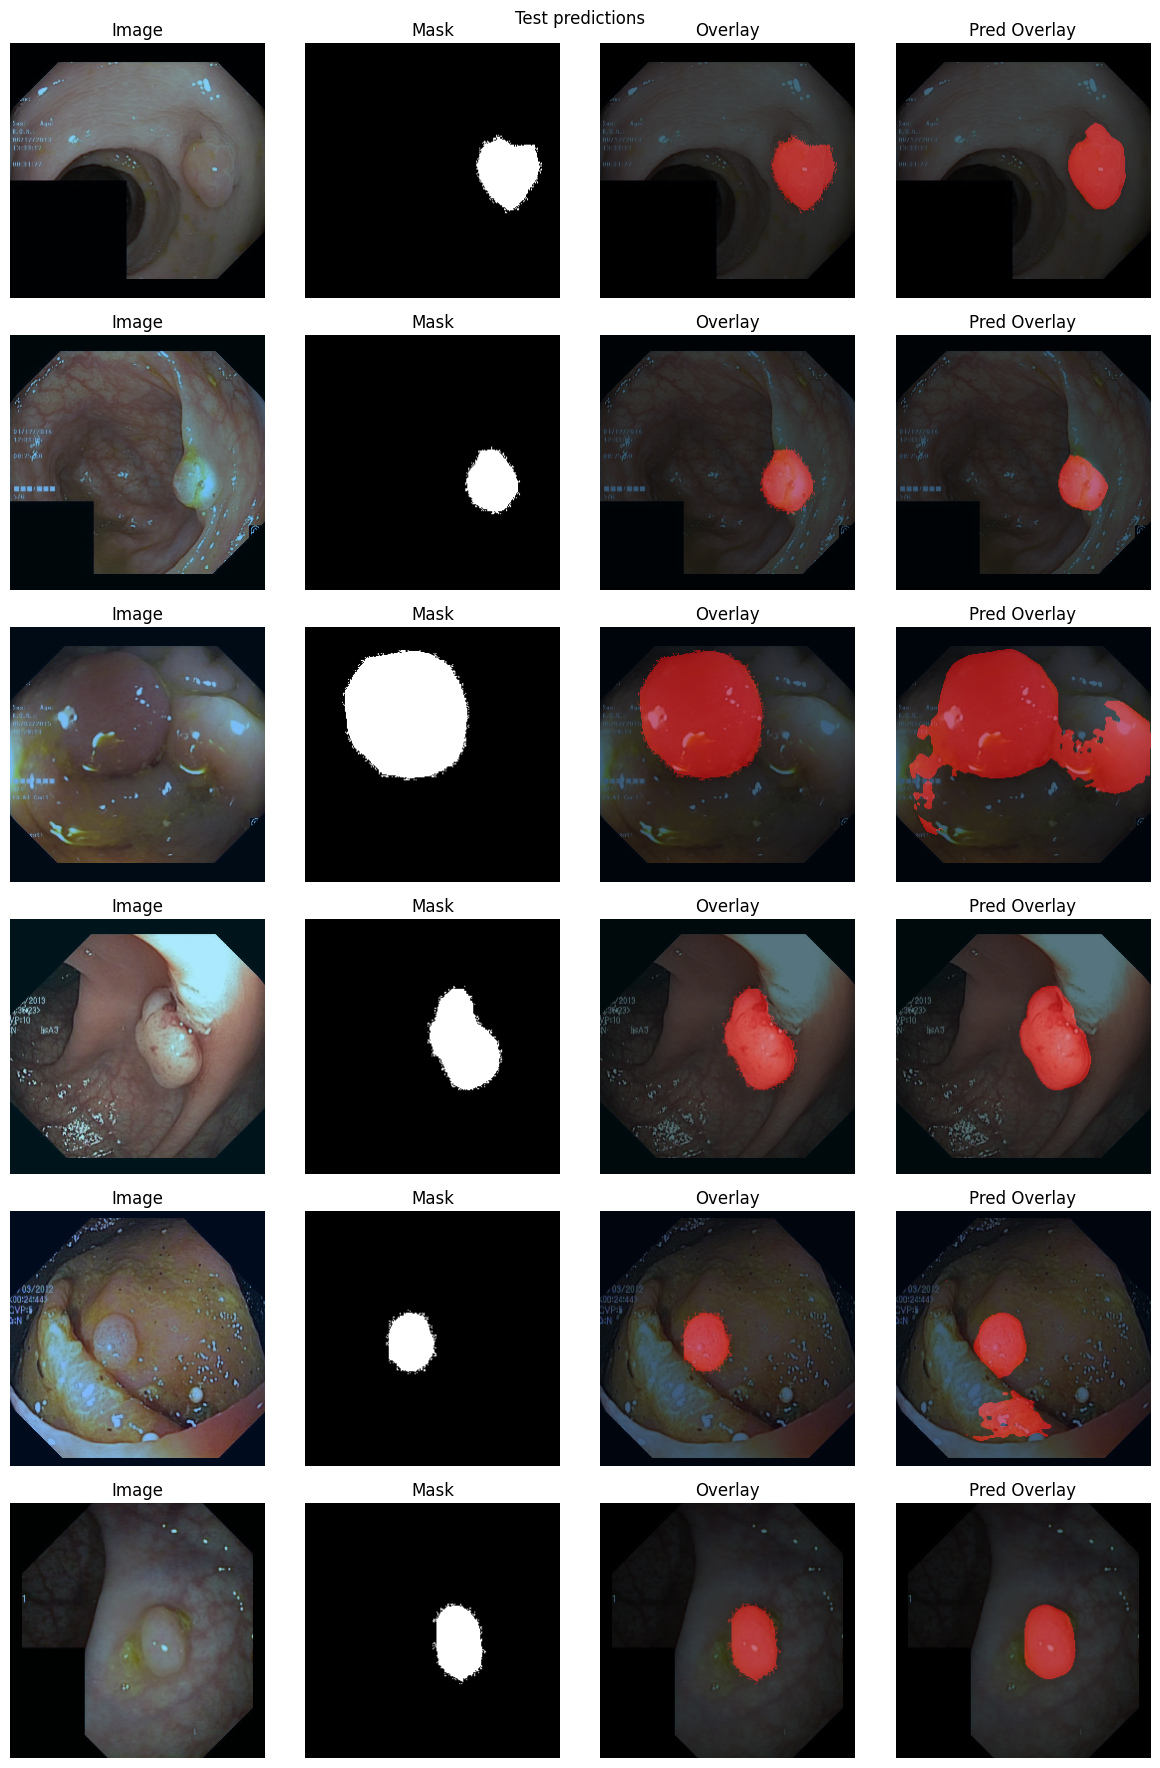

In [ ]:
# ============================================================
# Load Best Model and Evaluate on Test Set
# ============================================================
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])

test_metrics, viz_test = eval_one_epoch(model, dl_test, criterion_bce, criterion_dice, DEVICE)
print(f"[TEST] loss={test_metrics['loss']:.4f} | dice={test_metrics['dice']:.4f} | "
      f"iou={test_metrics['iou']:.4f} | bf={test_metrics['bf']:.4f}")

# visualize a few test predictions
imgs_t, masks_t, probs_t = viz_test
show_samples(imgs_t, masks_t, preds=probs_t, n=min(6, len(imgs_t)), title="Test predictions")


## **🚀 Step 18 – Inference on New Images**

- 🖼 **Folder prediction** → Run the trained model on any folder of images.  
- ⚡ **Transforms applied** → Each image is resized & normalized before inference.  
- 🎯 **Thresholding** → Converts probabilities into binary masks.  
- 💾 **Save outputs** → Predicted masks are stored in a `predictions/` directory.  


In [ ]:
# ============================================================
# Inference Helper: Predict on Arbitrary Folder
# ============================================================
@torch.no_grad()
def predict_folder(model, folder_images, out_dir="predictions", thr=0.5):
    model.eval()
    os.makedirs(out_dir, exist_ok=True)
    tfm = get_transforms("test", IMG_SIZE)

    img_paths = sorted(glob.glob(os.path.join(folder_images, "*.*")))
    for ip in img_paths:
        img = cv2.imread(ip, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = tfm(image=img_rgb)
        tin = augmented["image"].unsqueeze(0).to(DEVICE)
        logits = model(tin)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (prob > thr).astype(np.uint8)*255

        out_path = os.path.join(out_dir, Path(ip).stem + "_pred.png")
        cv2.imwrite(out_path, pred)
    print(f"Saved predictions to {out_dir}")

# Example (optional):
predict_folder(model, "data/images", out_dir="predictions", thr=0.5)


Saved predictions to predictions


/tmp/ipython-input-1105796552.py:8: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),


## **📊 Step 19 – Plot Training & Validation Curves**  

In this step, we parse the training logs and visualize how the model performed across epochs.  
We will plot four metrics: **Loss**, **Dice**, **IoU**, and **Boundary F1** for both training and validation sets.  

The plots make it easier to compare model learning and check for overfitting or underfitting trends.  


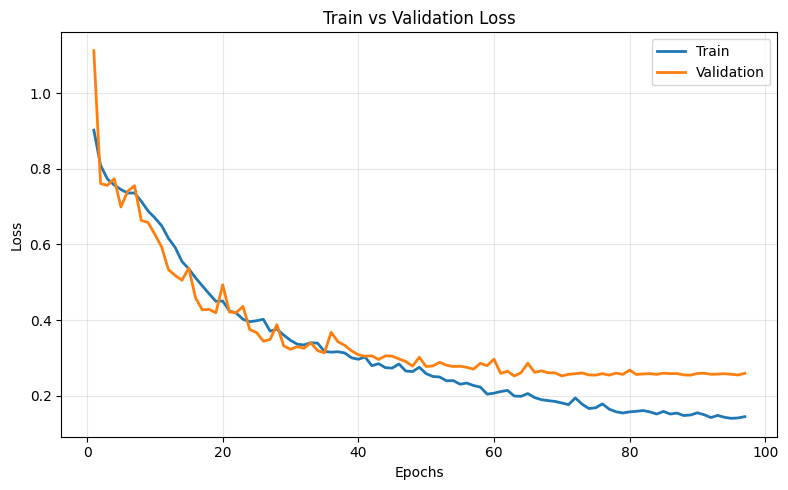

Saved: train_val_loss.png, train_val_dice.png, train_val_iou.png, train_val_bf.png


In [ ]:
# ================================
# Plot Train vs Val (loss/dice/iou/bf) from your logs
# ================================
import re
import matplotlib.pyplot as plt

# ---- 1) PASTE YOUR LOGS HERE ----
LOG_TEXT = r"""
<<PASTE YOUR FULL LOG TEXT HERE>>
Epoch 001/100 | Train: loss=0.9023, dice=0.3844, iou=0.2714, bf=0.0968 | Val:   loss=1.1122, dice=0.4253, iou=0.2930, bf=0.0803 | lr=0.001000 | ✅ Saved best | 370.9s
Epoch 002/100 | Train: loss=0.8089, dice=0.4183, iou=0.2997, bf=0.1017 | Val:   loss=0.7611, dice=0.4895, iou=0.3538, bf=0.1193 | lr=0.000999 | ✅ Saved best | 35.8s
Epoch 003/100 | Train: loss=0.7732, dice=0.4389, iou=0.3168, bf=0.1048 | Val:   loss=0.7562, dice=0.4144, iou=0.2978, bf=0.1094 | lr=0.000998 |  | 37.3s
Epoch 004/100 | Train: loss=0.7571, dice=0.4565, iou=0.3331, bf=0.1157 | Val:   loss=0.7738, dice=0.4597, iou=0.3256, bf=0.1153 | lr=0.000996 |  | 35.7s
Epoch 005/100 | Train: loss=0.7452, dice=0.4691, iou=0.3425, bf=0.1269 | Val:   loss=0.6991, dice=0.4973, iou=0.3680, bf=0.1309 | lr=0.000994 | ✅ Saved best | 37.2s
Epoch 006/100 | Train: loss=0.7358, dice=0.4814, iou=0.3570, bf=0.1445 | Val:   loss=0.7408, dice=0.4033, iou=0.3012, bf=0.1141 | lr=0.000991 |  | 35.2s
Epoch 007/100 | Train: loss=0.7362, dice=0.4717, iou=0.3492, bf=0.1304 | Val:   loss=0.7553, dice=0.3860, iou=0.2834, bf=0.0933 | lr=0.000988 |  | 36.3s
Epoch 008/100 | Train: loss=0.7141, dice=0.4857, iou=0.3652, bf=0.1498 | Val:   loss=0.6636, dice=0.5201, iou=0.3907, bf=0.1555 | lr=0.000984 | ✅ Saved best | 35.4s
Epoch 009/100 | Train: loss=0.6885, dice=0.5087, iou=0.3876, bf=0.1602 | Val:   loss=0.6580, dice=0.5149, iou=0.3968, bf=0.1721 | lr=0.000980 |  | 36.5s
Epoch 010/100 | Train: loss=0.6703, dice=0.5204, iou=0.4004, bf=0.1763 | Val:   loss=0.6266, dice=0.5424, iou=0.4202, bf=0.1785 | lr=0.000976 | ✅ Saved best | 35.6s
Epoch 011/100 | Train: loss=0.6496, dice=0.5390, iou=0.4162, bf=0.1834 | Val:   loss=0.5932, dice=0.5790, iou=0.4504, bf=0.2014 | lr=0.000970 | ✅ Saved best | 36.4s
Epoch 012/100 | Train: loss=0.6164, dice=0.5604, iou=0.4387, bf=0.1997 | Val:   loss=0.5336, dice=0.6365, iou=0.4983, bf=0.2346 | lr=0.000965 | ✅ Saved best | 36.8s
Epoch 013/100 | Train: loss=0.5919, dice=0.5890, iou=0.4652, bf=0.2228 | Val:   loss=0.5179, dice=0.6405, iou=0.5127, bf=0.2456 | lr=0.000959 | ✅ Saved best | 36.2s
Epoch 014/100 | Train: loss=0.5548, dice=0.6200, iou=0.4950, bf=0.2462 | Val:   loss=0.5053, dice=0.6460, iou=0.5203, bf=0.2645 | lr=0.000952 | ✅ Saved best | 37.6s
Epoch 015/100 | Train: loss=0.5356, dice=0.6313, iou=0.5096, bf=0.2590 | Val:   loss=0.5374, dice=0.6487, iou=0.5161, bf=0.2562 | lr=0.000946 | ✅ Saved best | 36.0s
Epoch 016/100 | Train: loss=0.5118, dice=0.6484, iou=0.5290, bf=0.2785 | Val:   loss=0.4588, dice=0.6853, iou=0.5699, bf=0.3245 | lr=0.000938 | ✅ Saved best | 37.7s
Epoch 017/100 | Train: loss=0.4905, dice=0.6645, iou=0.5458, bf=0.3046 | Val:   loss=0.4271, dice=0.7109, iou=0.5941, bf=0.3416 | lr=0.000930 | ✅ Saved best | 36.6s
Epoch 018/100 | Train: loss=0.4696, dice=0.6870, iou=0.5725, bf=0.3328 | Val:   loss=0.4281, dice=0.7167, iou=0.5977, bf=0.3444 | lr=0.000922 | ✅ Saved best | 36.9s
Epoch 019/100 | Train: loss=0.4497, dice=0.7004, iou=0.5872, bf=0.3470 | Val:   loss=0.4194, dice=0.7230, iou=0.6073, bf=0.3676 | lr=0.000914 | ✅ Saved best | 37.6s
Epoch 020/100 | Train: loss=0.4504, dice=0.6997, iou=0.5881, bf=0.3604 | Val:   loss=0.4932, dice=0.6240, iou=0.5249, bf=0.3582 | lr=0.000905 |  | 35.3s
Epoch 021/100 | Train: loss=0.4241, dice=0.7226, iou=0.6115, bf=0.3829 | Val:   loss=0.4214, dice=0.7044, iou=0.5986, bf=0.3852 | lr=0.000895 |  | 36.7s
Epoch 022/100 | Train: loss=0.4185, dice=0.7251, iou=0.6145, bf=0.3858 | Val:   loss=0.4199, dice=0.7207, iou=0.6077, bf=0.3866 | lr=0.000885 |  | 34.9s
Epoch 023/100 | Train: loss=0.4020, dice=0.7312, iou=0.6198, bf=0.3946 | Val:   loss=0.4360, dice=0.7070, iou=0.6047, bf=0.3961 | lr=0.000875 |  | 36.5s
Epoch 024/100 | Train: loss=0.3958, dice=0.7364, iou=0.6290, bf=0.4067 | Val:   loss=0.3747, dice=0.7411, iou=0.6395, bf=0.4211 | lr=0.000865 | ✅ Saved best | 35.4s
Epoch 025/100 | Train: loss=0.3982, dice=0.7380, iou=0.6306, bf=0.4138 | Val:   loss=0.3671, dice=0.7592, iou=0.6561, bf=0.4410 | lr=0.000854 | ✅ Saved best | 36.6s
Epoch 026/100 | Train: loss=0.4021, dice=0.7355, iou=0.6271, bf=0.4092 | Val:   loss=0.3443, dice=0.7698, iou=0.6654, bf=0.4558 | lr=0.000842 | ✅ Saved best | 36.3s
Epoch 027/100 | Train: loss=0.3707, dice=0.7588, iou=0.6575, bf=0.4422 | Val:   loss=0.3488, dice=0.7599, iou=0.6611, bf=0.4410 | lr=0.000831 |  | 35.7s
Epoch 028/100 | Train: loss=0.3761, dice=0.7539, iou=0.6535, bf=0.4454 | Val:   loss=0.3878, dice=0.7331, iou=0.6405, bf=0.4567 | lr=0.000819 |  | 35.8s
Epoch 029/100 | Train: loss=0.3602, dice=0.7607, iou=0.6595, bf=0.4488 | Val:   loss=0.3317, dice=0.7739, iou=0.6797, bf=0.4746 | lr=0.000807 | ✅ Saved best | 35.5s
Epoch 030/100 | Train: loss=0.3465, dice=0.7745, iou=0.6724, bf=0.4570 | Val:   loss=0.3228, dice=0.7734, iou=0.6778, bf=0.4556 | lr=0.000794 |  | 36.2s
Epoch 031/100 | Train: loss=0.3363, dice=0.7812, iou=0.6806, bf=0.4712 | Val:   loss=0.3297, dice=0.7793, iou=0.6819, bf=0.4840 | lr=0.000781 | ✅ Saved best | 35.4s
Epoch 032/100 | Train: loss=0.3342, dice=0.7818, iou=0.6818, bf=0.4720 | Val:   loss=0.3256, dice=0.7804, iou=0.6866, bf=0.4805 | lr=0.000768 | ✅ Saved best | 37.0s
Epoch 033/100 | Train: loss=0.3401, dice=0.7783, iou=0.6794, bf=0.4717 | Val:   loss=0.3400, dice=0.7688, iou=0.6716, bf=0.4624 | lr=0.000755 |  | 35.1s
Epoch 034/100 | Train: loss=0.3389, dice=0.7810, iou=0.6841, bf=0.4809 | Val:   loss=0.3194, dice=0.7934, iou=0.6926, bf=0.4887 | lr=0.000741 | ✅ Saved best | 36.5s
Epoch 035/100 | Train: loss=0.3172, dice=0.7936, iou=0.7011, bf=0.4976 | Val:   loss=0.3133, dice=0.7887, iou=0.6943, bf=0.4594 | lr=0.000727 |  | 35.1s
Epoch 036/100 | Train: loss=0.3152, dice=0.7931, iou=0.6982, bf=0.4898 | Val:   loss=0.3678, dice=0.7574, iou=0.6539, bf=0.4488 | lr=0.000713 |  | 35.7s
Epoch 037/100 | Train: loss=0.3163, dice=0.7928, iou=0.6957, bf=0.4863 | Val:   loss=0.3428, dice=0.7706, iou=0.6683, bf=0.4452 | lr=0.000699 |  | 35.1s
Epoch 038/100 | Train: loss=0.3130, dice=0.7986, iou=0.7059, bf=0.4985 | Val:   loss=0.3332, dice=0.7644, iou=0.6718, bf=0.4761 | lr=0.000684 |  | 35.4s
Epoch 039/100 | Train: loss=0.3003, dice=0.8055, iou=0.7113, bf=0.5052 | Val:   loss=0.3186, dice=0.7840, iou=0.6913, bf=0.4945 | lr=0.000670 |  | 35.6s
Epoch 040/100 | Train: loss=0.2964, dice=0.8089, iou=0.7169, bf=0.5169 | Val:   loss=0.3084, dice=0.7909, iou=0.6969, bf=0.5041 | lr=0.000655 |  | 35.3s
Epoch 041/100 | Train: loss=0.3023, dice=0.8065, iou=0.7131, bf=0.5117 | Val:   loss=0.3042, dice=0.7907, iou=0.6965, bf=0.4981 | lr=0.000640 |  | 36.1s
Epoch 042/100 | Train: loss=0.2794, dice=0.8169, iou=0.7267, bf=0.5243 | Val:   loss=0.3055, dice=0.7864, iou=0.6952, bf=0.4967 | lr=0.000625 |  | 35.5s
Epoch 043/100 | Train: loss=0.2847, dice=0.8149, iou=0.7232, bf=0.5155 | Val:   loss=0.2959, dice=0.8012, iou=0.7044, bf=0.5074 | lr=0.000609 | ✅ Saved best | 36.8s
Epoch 044/100 | Train: loss=0.2741, dice=0.8224, iou=0.7334, bf=0.5355 | Val:   loss=0.3054, dice=0.7964, iou=0.7039, bf=0.5048 | lr=0.000594 |  | 35.5s
Epoch 045/100 | Train: loss=0.2731, dice=0.8215, iou=0.7305, bf=0.5243 | Val:   loss=0.3047, dice=0.8026, iou=0.7078, bf=0.4993 | lr=0.000579 | ✅ Saved best | 37.1s
Epoch 046/100 | Train: loss=0.2840, dice=0.8127, iou=0.7215, bf=0.5172 | Val:   loss=0.2973, dice=0.8068, iou=0.7191, bf=0.5308 | lr=0.000563 | ✅ Saved best | 35.8s
Epoch 047/100 | Train: loss=0.2653, dice=0.8278, iou=0.7395, bf=0.5382 | Val:   loss=0.2905, dice=0.8042, iou=0.7144, bf=0.5255 | lr=0.000548 |  | 36.6s
Epoch 048/100 | Train: loss=0.2639, dice=0.8336, iou=0.7436, bf=0.5339 | Val:   loss=0.2782, dice=0.8179, iou=0.7297, bf=0.5384 | lr=0.000532 | ✅ Saved best | 36.1s
Epoch 049/100 | Train: loss=0.2753, dice=0.8215, iou=0.7322, bf=0.5312 | Val:   loss=0.3018, dice=0.8044, iou=0.7124, bf=0.5198 | lr=0.000516 |  | 36.3s
Epoch 050/100 | Train: loss=0.2584, dice=0.8333, iou=0.7464, bf=0.5399 | Val:   loss=0.2772, dice=0.8140, iou=0.7240, bf=0.5074 | lr=0.000501 |  | 36.8s
Epoch 051/100 | Train: loss=0.2509, dice=0.8369, iou=0.7507, bf=0.5501 | Val:   loss=0.2788, dice=0.8149, iou=0.7273, bf=0.5246 | lr=0.000485 |  | 35.3s
Epoch 052/100 | Train: loss=0.2495, dice=0.8376, iou=0.7519, bf=0.5518 | Val:   loss=0.2884, dice=0.8068, iou=0.7227, bf=0.5416 | lr=0.000469 |  | 36.7s
Epoch 053/100 | Train: loss=0.2395, dice=0.8485, iou=0.7633, bf=0.5579 | Val:   loss=0.2806, dice=0.8101, iou=0.7277, bf=0.5353 | lr=0.000453 |  | 35.2s
Epoch 054/100 | Train: loss=0.2400, dice=0.8498, iou=0.7650, bf=0.5655 | Val:   loss=0.2772, dice=0.8125, iou=0.7223, bf=0.5434 | lr=0.000438 |  | 36.8s
Epoch 055/100 | Train: loss=0.2305, dice=0.8534, iou=0.7710, bf=0.5711 | Val:   loss=0.2781, dice=0.8073, iou=0.7204, bf=0.5322 | lr=0.000422 |  | 35.4s
Epoch 056/100 | Train: loss=0.2335, dice=0.8475, iou=0.7660, bf=0.5652 | Val:   loss=0.2750, dice=0.8104, iou=0.7252, bf=0.5322 | lr=0.000407 |  | 36.9s
Epoch 057/100 | Train: loss=0.2269, dice=0.8526, iou=0.7687, bf=0.5728 | Val:   loss=0.2704, dice=0.8150, iou=0.7293, bf=0.5444 | lr=0.000392 |  | 35.6s
Epoch 058/100 | Train: loss=0.2228, dice=0.8555, iou=0.7754, bf=0.5766 | Val:   loss=0.2857, dice=0.8110, iou=0.7300, bf=0.5480 | lr=0.000376 |  | 36.4s
Epoch 059/100 | Train: loss=0.2042, dice=0.8714, iou=0.7931, bf=0.5956 | Val:   loss=0.2793, dice=0.8098, iou=0.7231, bf=0.5360 | lr=0.000361 |  | 36.6s
Epoch 060/100 | Train: loss=0.2067, dice=0.8668, iou=0.7895, bf=0.5910 | Val:   loss=0.2968, dice=0.8023, iou=0.7076, bf=0.5175 | lr=0.000346 |  | 35.6s
Epoch 061/100 | Train: loss=0.2110, dice=0.8631, iou=0.7846, bf=0.5812 | Val:   loss=0.2591, dice=0.8307, iou=0.7476, bf=0.5698 | lr=0.000331 | ✅ Saved best | 37.3s
Epoch 062/100 | Train: loss=0.2141, dice=0.8627, iou=0.7820, bf=0.5880 | Val:   loss=0.2647, dice=0.8194, iou=0.7332, bf=0.5486 | lr=0.000317 |  | 36.0s
Epoch 063/100 | Train: loss=0.1992, dice=0.8715, iou=0.7950, bf=0.5987 | Val:   loss=0.2523, dice=0.8268, iou=0.7438, bf=0.5623 | lr=0.000302 |  | 36.9s
Epoch 064/100 | Train: loss=0.1984, dice=0.8705, iou=0.7955, bf=0.6012 | Val:   loss=0.2608, dice=0.8209, iou=0.7384, bf=0.5566 | lr=0.000288 |  | 35.5s
Epoch 065/100 | Train: loss=0.2057, dice=0.8666, iou=0.7899, bf=0.6006 | Val:   loss=0.2860, dice=0.8100, iou=0.7171, bf=0.5296 | lr=0.000274 |  | 36.9s
Epoch 066/100 | Train: loss=0.1952, dice=0.8697, iou=0.7928, bf=0.5940 | Val:   loss=0.2618, dice=0.8270, iou=0.7422, bf=0.5616 | lr=0.000260 |  | 35.9s
Epoch 067/100 | Train: loss=0.1895, dice=0.8784, iou=0.8028, bf=0.6068 | Val:   loss=0.2658, dice=0.8271, iou=0.7461, bf=0.5678 | lr=0.000246 |  | 35.8s
Epoch 068/100 | Train: loss=0.1871, dice=0.8812, iou=0.8071, bf=0.6122 | Val:   loss=0.2608, dice=0.8234, iou=0.7402, bf=0.5617 | lr=0.000233 |  | 36.7s
Epoch 069/100 | Train: loss=0.1849, dice=0.8803, iou=0.8072, bf=0.6144 | Val:   loss=0.2604, dice=0.8261, iou=0.7452, bf=0.5729 | lr=0.000220 |  | 35.5s
Epoch 070/100 | Train: loss=0.1809, dice=0.8824, iou=0.8083, bf=0.6123 | Val:   loss=0.2525, dice=0.8322, iou=0.7494, bf=0.5757 | lr=0.000207 | ✅ Saved best | 37.0s
Epoch 071/100 | Train: loss=0.1764, dice=0.8877, iou=0.8143, bf=0.6220 | Val:   loss=0.2564, dice=0.8340, iou=0.7494, bf=0.5631 | lr=0.000194 | ✅ Saved best | 35.9s
Epoch 072/100 | Train: loss=0.1942, dice=0.8744, iou=0.8006, bf=0.6086 | Val:   loss=0.2581, dice=0.8369, iou=0.7506, bf=0.5662 | lr=0.000182 | ✅ Saved best | 37.3s
Epoch 073/100 | Train: loss=0.1777, dice=0.8840, iou=0.8114, bf=0.6175 | Val:   loss=0.2603, dice=0.8294, iou=0.7464, bf=0.5680 | lr=0.000170 |  | 35.6s
Epoch 074/100 | Train: loss=0.1662, dice=0.8945, iou=0.8236, bf=0.6338 | Val:   loss=0.2551, dice=0.8315, iou=0.7487, bf=0.5701 | lr=0.000159 |  | 36.2s
Epoch 075/100 | Train: loss=0.1681, dice=0.8893, iou=0.8170, bf=0.6199 | Val:   loss=0.2545, dice=0.8303, iou=0.7501, bf=0.5712 | lr=0.000147 |  | 36.3s
Epoch 076/100 | Train: loss=0.1784, dice=0.8842, iou=0.8111, bf=0.6193 | Val:   loss=0.2583, dice=0.8271, iou=0.7456, bf=0.5683 | lr=0.000136 |  | 35.7s
Epoch 077/100 | Train: loss=0.1645, dice=0.8934, iou=0.8227, bf=0.6291 | Val:   loss=0.2544, dice=0.8393, iou=0.7574, bf=0.5869 | lr=0.000126 | ✅ Saved best | 37.2s
Epoch 078/100 | Train: loss=0.1576, dice=0.8969, iou=0.8276, bf=0.6332 | Val:   loss=0.2597, dice=0.8319, iou=0.7474, bf=0.5668 | lr=0.000116 |  | 36.0s
Epoch 079/100 | Train: loss=0.1543, dice=0.9023, iou=0.8337, bf=0.6405 | Val:   loss=0.2564, dice=0.8336, iou=0.7502, bf=0.5758 | lr=0.000106 |  | 36.9s
Epoch 080/100 | Train: loss=0.1573, dice=0.8988, iou=0.8287, bf=0.6363 | Val:   loss=0.2678, dice=0.8242, iou=0.7383, bf=0.5590 | lr=0.000096 |  | 35.5s
Epoch 081/100 | Train: loss=0.1587, dice=0.8982, iou=0.8288, bf=0.6368 | Val:   loss=0.2562, dice=0.8336, iou=0.7502, bf=0.5774 | lr=0.000087 |  | 36.9s
Epoch 082/100 | Train: loss=0.1609, dice=0.8962, iou=0.8265, bf=0.6355 | Val:   loss=0.2576, dice=0.8285, iou=0.7495, bf=0.5785 | lr=0.000079 |  | 35.6s
Epoch 083/100 | Train: loss=0.1571, dice=0.8965, iou=0.8289, bf=0.6383 | Val:   loss=0.2584, dice=0.8247, iou=0.7456, bf=0.5733 | lr=0.000071 |  | 36.1s
Epoch 084/100 | Train: loss=0.1516, dice=0.9008, iou=0.8323, bf=0.6407 | Val:   loss=0.2565, dice=0.8310, iou=0.7507, bf=0.5816 | lr=0.000063 |  | 36.6s
Epoch 085/100 | Train: loss=0.1585, dice=0.8983, iou=0.8314, bf=0.6416 | Val:   loss=0.2598, dice=0.8314, iou=0.7515, bf=0.5760 | lr=0.000055 |  | 35.7s
Epoch 086/100 | Train: loss=0.1516, dice=0.8994, iou=0.8318, bf=0.6397 | Val:   loss=0.2582, dice=0.8317, iou=0.7535, bf=0.5836 | lr=0.000049 |  | 37.0s
Epoch 087/100 | Train: loss=0.1541, dice=0.8990, iou=0.8309, bf=0.6382 | Val:   loss=0.2588, dice=0.8288, iou=0.7490, bf=0.5756 | lr=0.000042 |  | 35.7s
Epoch 088/100 | Train: loss=0.1476, dice=0.9029, iou=0.8360, bf=0.6413 | Val:   loss=0.2550, dice=0.8334, iou=0.7531, bf=0.5833 | lr=0.000036 |  | 37.0s
Epoch 089/100 | Train: loss=0.1491, dice=0.9031, iou=0.8356, bf=0.6488 | Val:   loss=0.2544, dice=0.8322, iou=0.7536, bf=0.5851 | lr=0.000031 |  | 35.5s
Epoch 090/100 | Train: loss=0.1549, dice=0.8998, iou=0.8315, bf=0.6422 | Val:   loss=0.2589, dice=0.8292, iou=0.7499, bf=0.5761 | lr=0.000025 |  | 36.9s
Epoch 091/100 | Train: loss=0.1497, dice=0.9024, iou=0.8366, bf=0.6487 | Val:   loss=0.2595, dice=0.8312, iou=0.7517, bf=0.5802 | lr=0.000021 |  | 35.5s
Epoch 092/100 | Train: loss=0.1423, dice=0.9073, iou=0.8408, bf=0.6496 | Val:   loss=0.2567, dice=0.8320, iou=0.7516, bf=0.5749 | lr=0.000017 |  | 36.5s
Epoch 093/100 | Train: loss=0.1481, dice=0.9033, iou=0.8369, bf=0.6512 | Val:   loss=0.2572, dice=0.8321, iou=0.7522, bf=0.5787 | lr=0.000013 |  | 36.0s
Epoch 094/100 | Train: loss=0.1429, dice=0.9060, iou=0.8386, bf=0.6482 | Val:   loss=0.2582, dice=0.8323, iou=0.7532, bf=0.5811 | lr=0.000010 |  | 36.0s
Epoch 095/100 | Train: loss=0.1402, dice=0.9068, iou=0.8419, bf=0.6510 | Val:   loss=0.2567, dice=0.8319, iou=0.7537, bf=0.5813 | lr=0.000007 |  | 36.4s
Epoch 096/100 | Train: loss=0.1413, dice=0.9076, iou=0.8413, bf=0.6490 | Val:   loss=0.2548, dice=0.8340, iou=0.7545, bf=0.5809 | lr=0.000005 |  | 35.5s
Epoch 097/100 | Train: loss=0.1446, dice=0.9041, iou=0.8366, bf=0.6458 | Val:   loss=0.2593, dice=0.8319, iou=0.7531, bf=0.5814 | lr=0.000003 |  | 36.9s
"""

# ---- 2) Parse logs (handles both "Epoch" and the first "poch" typo) ----
pattern = re.compile(
    r'(?i)poch\s+(\d+)/\d+\s*\|\s*Train:\s*loss=([0-9.]+),\s*dice=([0-9.]+),\s*iou=([0-9.]+),\s*bf=([0-9.]+)\s*\|\s*Val:\s*loss=([0-9.]+),\s*dice=([0-9.]+),\s*iou=([0-9.]+),\s*bf=([0-9.]+)'
)

rows = []
for m in pattern.finditer(LOG_TEXT):
    ep = int(m.group(1))
    tr_loss, tr_dice, tr_iou, tr_bf = map(float, m.group(2,3,4,5))
    va_loss, va_dice, va_iou, va_bf = map(float, m.group(6,7,8,9))
    rows.append((ep, tr_loss, tr_dice, tr_iou, tr_bf, va_loss, va_dice, va_iou, va_bf))

if not rows:
    raise ValueError("No epochs parsed. Make sure you pasted the logs exactly as printed.")

# sort by epoch
rows.sort(key=lambda x: x[0])
epochs   = [r[0] for r in rows]
tr_loss  = [r[1] for r in rows];  va_loss = [r[5] for r in rows]
tr_dice  = [r[2] for r in rows];  va_dice = [r[6] for r in rows]
tr_iou   = [r[3] for r in rows];  va_iou  = [r[7] for r in rows]
tr_bf    = [r[4] for r in rows];  va_bf   = [r[8] for r in rows]

# ---- 3) Helper to plot a single metric (same size for all) ----
def plot_metric(x, y_train, y_val, title, ylabel, save_as=None):
    plt.figure(figsize=(8,5))     # same size for every figure
    plt.plot(x, y_train, label="Train", linewidth=2)
    plt.plot(x, y_val,   label="Validation", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=150)
    plt.show()

# ---- 4) Make the four separate figures ----
plot_metric(epochs, tr_loss, va_loss, "Train vs Validation Loss", "Loss", "train_val_loss.png")


print("Saved: train_val_loss.png, train_val_dice.png, train_val_iou.png, train_val_bf.png")


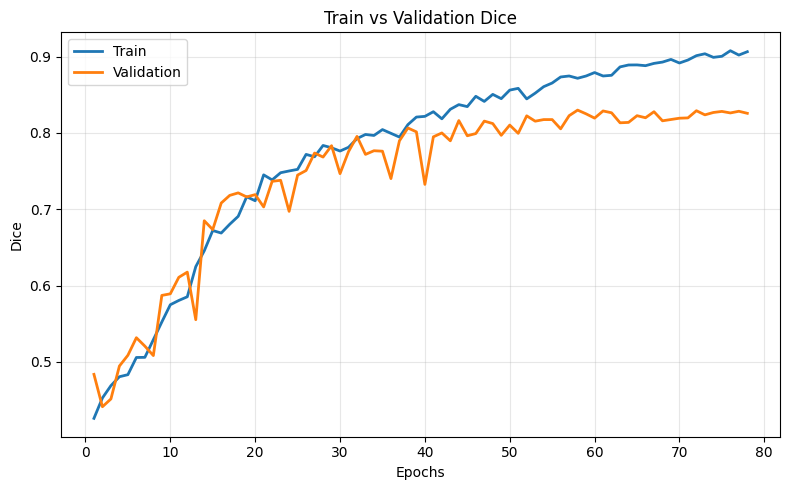

In [ ]:
plot_metric(epochs, tr_dice, va_dice, "Train vs Validation Dice", "Dice", "train_val_dice.png")


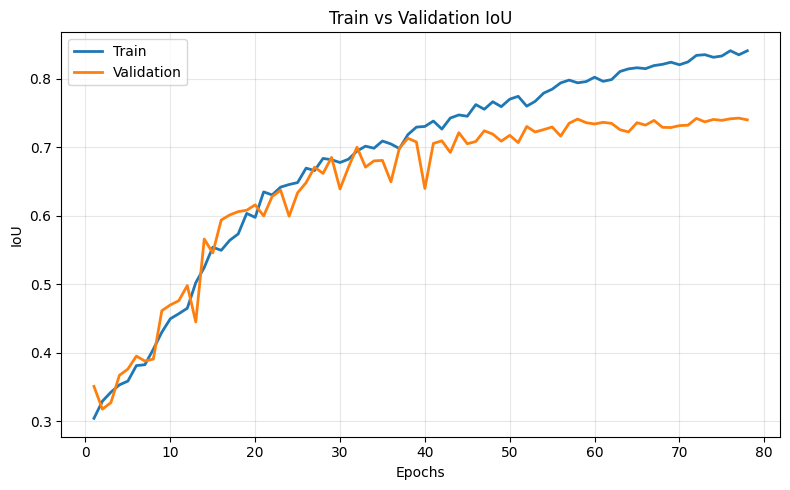

In [ ]:
plot_metric(epochs, tr_iou,  va_iou,  "Train vs Validation IoU", "IoU",  "train_val_iou.png")


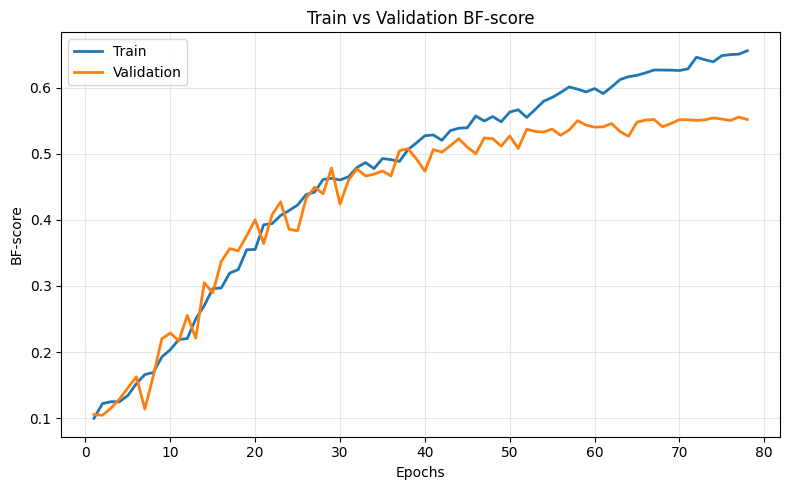

In [ ]:
plot_metric(epochs, tr_bf,   va_bf,   "Train vs Validation BF-score", "BF-score", "train_val_bf.png")

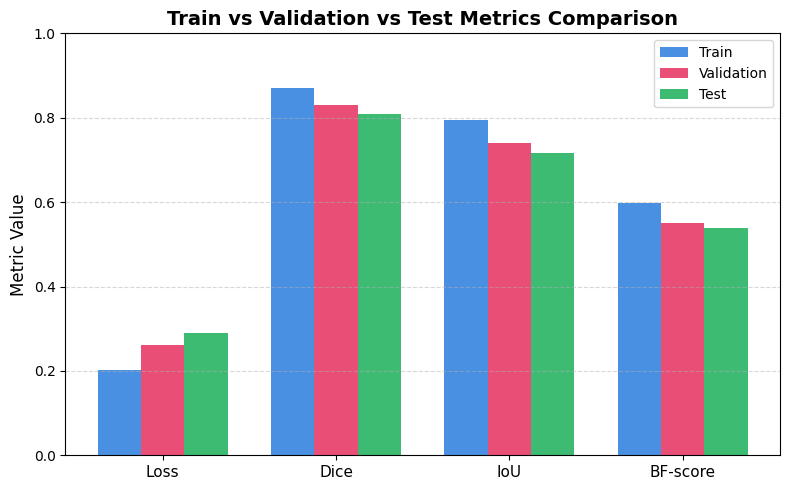

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Final Metrics ====
# Train metrics
train_loss = 0.2018
train_dice = 0.8716
train_iou  = 0.7940
train_bf   = 0.5979

# Validation metrics
val_loss = 0.2608
val_dice = 0.8299
val_iou  = 0.7411
val_bf   = 0.5502

# Test metrics
test_loss = 0.2905
test_dice = 0.8093
test_iou  = 0.7159
test_bf   = 0.5377

# ==== Prepare data ====
metrics = ["Loss", "Dice", "IoU", "BF-score"]
train_vals = [train_loss, train_dice, train_iou, train_bf]
val_vals   = [val_loss, val_dice, val_iou, val_bf]
test_vals  = [test_loss, test_dice, test_iou, test_bf]

x = np.arange(len(metrics))  # metric positions
bar_width = 0.25             # width of bars

# ==== Plot ====
plt.figure(figsize=(8,5))
plt.bar(x - bar_width, train_vals, width=bar_width, color="#4a90e2", label="Train")
plt.bar(x, val_vals, width=bar_width, color="#e94e77", label="Validation")
plt.bar(x + bar_width, test_vals, width=bar_width, color="#3dbb73", label="Test")

# Labels & Styling
plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Metric Value", fontsize=12)
plt.title("Train vs Validation vs Test Metrics Comparison", fontsize=14, weight="bold")
plt.ylim(0, 1)  # since most metrics are between 0 and 1
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
